[2017-07-28 11:34:44,599] Making new env: FrozenLake-v0


Episode:  99 0.03
Episode:  199 0.175
Episode:  299 0.293333333333
Episode:  399 0.3375
Episode:  499 0.386
Episode:  599 0.401666666667
Episode:  699 0.432857142857
Episode:  799 0.44625
Episode:  899 0.465555555556
Episode:  999 0.475
Episode:  1099 0.481818181818
Episode:  1199 0.49
Episode:  1299 0.502307692308
Episode:  1399 0.507857142857
Episode:  1499 0.517333333333
Episode:  1599 0.52875
Episode:  1699 0.536470588235
Episode:  1799 0.543333333333
Episode:  1899 0.551052631579
Episode:  1999 0.558
Episode:  2099 0.562857142857
Episode:  2199 0.565909090909
Episode:  2299 0.57
Episode:  2399 0.57375
Episode:  2499 0.5764
Episode:  2599 0.578076923077
Episode:  2699 0.584074074074
Episode:  2799 0.5875
Episode:  2899 0.59
Episode:  2999 0.590666666667
Episode:  3099 0.591612903226
Episode:  3199 0.591875
Episode:  3299 0.593636363636
Episode:  3399 0.595294117647
Episode:  3499 0.597428571429
Episode:  3599 0.599722222222
Episode:  3699 0.601621621622
Episode:  3799 0.60315789473

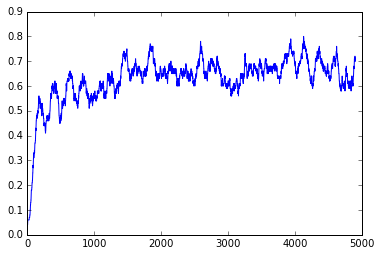

In [1]:
import numpy as np
import tensorflow as tf
import gym
import random
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

env = gym.make('FrozenLake-v0')
max_num_episodes = 5000
checkpoint = 100
replay_experience_maxlen = 50000
batch_size = 64

learning_rate = 0.001
decay = 0.99

tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=(None, 4 * 4))
y = tf.placeholder(dtype=tf.float32, shape=(None, 4))
Q = tf.contrib.layers.fully_connected(X, 4, activation_fn=None)
mse = tf.contrib.losses.mean_squared_error(y, Q)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

id16 = np.identity(16)
all_rewards = []

def onehot(x):
    return id16[x : x + 1]

def stats(rewards):
    print("Mean reward: ", np.mean(rewards))
    rewards_100 = []
    for i in range(100, len(rewards) + 1):
        rewards_100.append(np.mean(rewards[i-100:i]))
    print("Max 100 rewards mean: ", np.max(rewards_100))
    re = np.argmax(rewards_100)
    print("Max 100 rewards from episode: %d, to episode: %d" % (re - 100, re))
    plt.plot(rewards_100)
    plt.show()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Initialize empty experiences
replay_experience = deque(maxlen=replay_experience_maxlen)
for episode in range(max_num_episodes):
    state = env.reset()
    epsilon = 1./((episode/50) + 10)
    done = False
    while not done:
        # Calculate Q(s, a) for all a
        Q_s_A = Q.eval(feed_dict={X: onehot(state)})
        
        # Choose action based on epsilon-greedy policy
        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_s_A[0])

        # Perform action
        next_state, reward, done, _ = env.step(action)

        # Append final reward for each episode
        if done:
            all_rewards.append(reward)

        # Change 0 reward to -1 to learn more from punishment
        if done and reward < 0.5:
            reward = -1.0

        # Save experience
        replay_experience.append([onehot(state), action, reward, onehot(next_state), done])

        # Switch to next state
        state = next_state
        
        # Do training if replay_experience contains enough sample > batch_size
        if len(replay_experience) > batch_size:
            ## 1- Sample from replay experience
            batch = random.sample(replay_experience, batch_size)
            states = np.vstack([x[0] for x in batch])
            actions = np.array([x[1] for x in batch])
            rewards = np.array([x[2] for x in batch])
            next_states = np.vstack([x[3] for x in batch])
            episodes_done = np.array([x[4] for x in batch])
            target_Q = Q.eval(feed_dict={X: states})
            target_Q[range(batch_size), actions] = rewards + decay * np.max(Q.eval(feed_dict={X: next_states}), axis=1) * ~episodes_done
            train_step.run(feed_dict={X: states, y: target_Q})
            
    if (episode + 1) % checkpoint == 0:
        print("Episode: ", episode, np.mean(all_rewards))
    
    if len(all_rewards) >= 100 and np.mean(all_rewards[-100:]) >= 0.85:
        break

env.close()
stats(all_rewards)